In [593]:
import pandas as pd
import numpy as np
import glob
from src.stats import compute_stats
import torch
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt

In [551]:
models = ['baseline', 'vim2020', 'vim-sm4-305', 'vim2020-hpo']
fancy_name = ['Baseline MobileNet', 'ViM-small 20x20',  'ViM-small-segmamba 30x5', 'ViM-small 20x20 HPO']
splits = ['easy', 'hard', 'zeroshot']
keys = ['seg', 'class', 'seg_pred', 'class_pred']
resolutions = [None, 2, 100]

resmap = {None: '10ms Resolution', 2: '20ms Resolution', 100: '1s Resolution'}

In [ ]:
stats = pd.DataFrame(columns=['model','split','resolution','score','class_accuracy','class_roc_auc','segment_f1','segment_precision', 'segment_recall', 'segment_avg_precision'])
class_rocs = {}
seg_prs = {}

class_rocs_all = {}
seg_prs_all = {}

for model in models:
    print(model)
    all_labels = []
    all_labels_ = []
    all_segs = []
    all_segs_ = []
    for split in splits:
        print(f"  {split}")
        arrays = {k: torch.tensor(np.genfromtxt(f'stats/{model}_{split}_{k}.csv', delimiter=',')) for k in keys}
        labels, labels_, segs, segs_ = arrays['class'], arrays['class_pred'], arrays['seg'], arrays['seg_pred']
        all_labels.append(labels)
        all_labels_.append(labels_)
        all_segs.append(segs.view(-1))
        all_segs_.append(segs_.view(-1))
        class_rocs[f'{model}_{split}'] = metrics.RocCurveDisplay.from_predictions(labels, labels_, name=fancy_name[models.index(model)])
        seg_prs[f'{model}_{split}'] = metrics.PrecisionRecallDisplay.from_predictions(segs.view(-1), segs_.view(-1), name=fancy_name[models.index(model)])
        class_roc_auc = roc_auc_score(labels, labels_)
        # print(len(seg_rocs[f'{model}_{split}']))
        seg_pr_auc = metrics.average_precision_score(segs.view(-1), segs_.view(-1))
        print(f"     class_roc_auc: {class_roc_auc}")
        print(f"     seg_avg_precision: {seg_pr_auc}")
        for r in resolutions:
            print(f"    {r} scale")
            score, class_acc, seg_prec, seg_recall, seg_f1 = compute_stats(labels_.unsqueeze(1), segs_, labels, segs, scale=r)
            print(f"      score: {score}")
            print(f"      class_accuracy: {class_acc}")
            print(f"      seg_f1: {seg_f1}")
            print(f"      seg_precision: {seg_prec}")
            print(f"      seg_recall: {seg_recall}")

            row = pd.DataFrame([{'model': fancy_name[models.index(model)], 'split': split, 'resolution': resmap[r], 'score': score.item(), 'class_accuracy': class_acc.item(), 'class_roc_auc': class_roc_auc, 'segment_f1': seg_f1, 'segment_precision': seg_prec, 'segment_recall': seg_recall, 'segment_avg_precision': seg_pr_auc}])
            row = row.round(3)
            stats = pd.concat([stats, row])
    class_rocs_all[f'{model}'] = metrics.RocCurveDisplay.from_predictions(torch.concat(all_labels, axis=0), torch.concat(all_labels_, axis=0), name=fancy_name[models.index(model)])
    seg_prs_all[f'{model}'] = metrics.PrecisionRecallDisplay.from_predictions(torch.concat(all_segs, axis=0), torch.concat(all_segs_, axis=0), name=fancy_name[models.index(model)])


In [553]:
easy = stats[stats['split'] == 'easy'].drop('split', axis=1)
hard = stats[stats['split'] == 'hard'].drop('split', axis=1)
zeroshot = stats[stats['split'] == 'zeroshot'].drop('split', axis=1)

In [511]:
zeroshot

,model,resolution,score,class_accuracy,class_roc_auc,segment_f1,segment_precision,segment_recall,segment_avg_precision
0,Baseline MobileNet,10ms Resolution,0.146,0.486,0.652,0.000,0.023,0.000,0.176
0,Baseline MobileNet,20ms Resolution,0.146,0.486,0.652,0.000,0.030,0.000,0.176
0,Baseline MobileNet,1s Resolution,0.149,0.486,0.652,0.005,0.333,0.003,0.176
0,ViM-small 20x20,10ms Resolution,0.331,0.595,0.704,0.218,0.352,0.157,0.223
0,ViM-small 20x20,20ms Resolution,0.332,0.595,0.704,0.219,0.352,0.158,0.223
0,ViM-small 20x20,1s Resolution,0.370,0.595,0.704,0.273,0.376,0.215,0.223
0,ViM-small-segmamba 30x5,10ms Resolution,0.344,0.669,0.722,0.205,0.414,0.136,0.252
0,ViM-small-segmamba 30x5,20ms Resolution,0.346,0.669,0.722,0.208,0.413,0.139,0.252
0,ViM-small-segmamba 30x5,1s Resolution,0.413,0.669,0.722,0.303,0.418,0.237,0.252
0,ViM-small 20x20 HPO,10ms Resolution,0.360,0.623,0.633,0.247,0.302,0.209,0.205


In [554]:
def rename(df):
    return df.rename(columns={
        'score': '$Score$',
        'class_accuracy': '$Acc_{identify}$',
        'segment_f1': '$F1_{segment}$',
        'segment_precision': '$Precision_{segment}$',
        'segment_recall': '$Recall_{segment}$',
    })

In [555]:
def pivot_res_small(df):
    df = df.drop(['segment_precision', 'segment_recall', 'segment_avg_precision', 'class_roc_auc'], axis=1)
    df = df.rename(columns={'model': "Model", 'class_accuracy': '$Acc_{identify}$', 'resolution': "Resolution"})
    df = df.pivot(index=['Model', '$Acc_{identify}$'], columns='Resolution', 
                    values=['score', 'segment_f1'])
    df = df.swaplevel(0, 1, axis=1)
    df = df.sort_index(axis=1, ascending=True)
    return rename(df)

In [556]:
def pivot_res(df):
    df = df.rename(columns={'model': "Model", 'resolution': "Resolution", 'class_accuracy': '$Acc_{identify}$', 'class_roc_auc': '$AUC_{identify}$',
        'segment_avg_precision': "$AP_{segment}$"})
    df = df.pivot(index=['Model', '$Acc_{identify}$', '$AUC_{identify}$', '$AP_{segment}$'], columns='Resolution', 
                    values=['score', 'segment_f1', 'segment_precision', 'segment_recall'])
    df = df.swaplevel(0, 1, axis=1)
    df = df.sort_index(axis=1, ascending=True)
    return rename(df)

In [557]:
def table_res(df, res, insert_split=None):
    df = df.loc[:, [res]]
    df.columns = df.columns.get_level_values(1)
    df = df.reset_index()
    if insert_split:
        df['Test Subset'] = insert_split
    return df.reset_index(drop=True)

In [558]:
def awesome_table():
    e = table_res(pivot_res(easy), '10ms Resolution', insert_split=None).iloc[:, [0,1,4,5,6,7]]
    h = table_res(pivot_res(hard), '10ms Resolution', insert_split=None).iloc[:, [0,1,4,5,6,7]]
    z = table_res(pivot_res(zeroshot), '10ms Resolution', insert_split=None).iloc[:, [0,1,4,5,6,7]]

    # print(e)
    # print(h)
    # print(z)
    
    t = pd.concat([e, h, z], ignore_index=True)

    # t = t.pivot(index=['Model'], columns='Test Subset', 
    #         values=['$Acc_{identify}$', '$Score$','$F1_{segment}$'])

    # t = t.swaplevel(0, 1, axis=1)
    # t = t.sort_index(axis=1, ascending=True)
    
    return t

In [559]:
awesome_table()

,Model,$Acc_{identify}$,$Score$,$F1_{segment}$,$Precision_{segment}$,$Recall_{segment}$
0,Baseline MobileNet,0.500,0.244,0.134,0.793,0.073
1,ViM-small 20x20,0.814,0.724,0.685,0.801,0.599
2,ViM-small 20x20 HPO,0.791,0.621,0.549,0.568,0.530
3,ViM-small-segmamba 30x5,0.802,0.717,0.680,0.750,0.622
4,Baseline MobileNet,0.611,0.261,0.112,0.514,0.063
5,ViM-small 20x20,0.700,0.450,0.342,0.472,0.268
6,ViM-small 20x20 HPO,0.642,0.422,0.328,0.393,0.282
7,ViM-small-segmamba 30x5,0.778,0.482,0.355,0.542,0.264
8,Baseline MobileNet,0.486,0.146,0.000,0.023,0.000
9,ViM-small 20x20,0.595,0.331,0.218,0.352,0.157


In [560]:
print(awesome_table().to_latex(float_format='%0.3f', index_names=False, index=False))

\begin{tabular}{lrrrrr}
\toprule
Model & $Acc_{identify}$ & $Score$ & $F1_{segment}$ & $Precision_{segment}$ & $Recall_{segment}$ \\
\midrule
Baseline MobileNet & 0.500 & 0.244 & 0.134 & 0.793 & 0.073 \\
ViM-small 20x20 & 0.814 & 0.724 & 0.685 & 0.801 & 0.599 \\
ViM-small 20x20 HPO & 0.791 & 0.621 & 0.549 & 0.568 & 0.530 \\
ViM-small-segmamba 30x5 & 0.802 & 0.717 & 0.680 & 0.750 & 0.622 \\
Baseline MobileNet & 0.611 & 0.261 & 0.112 & 0.514 & 0.063 \\
ViM-small 20x20 & 0.700 & 0.450 & 0.342 & 0.472 & 0.268 \\
ViM-small 20x20 HPO & 0.642 & 0.422 & 0.328 & 0.393 & 0.282 \\
ViM-small-segmamba 30x5 & 0.778 & 0.482 & 0.355 & 0.542 & 0.264 \\
Baseline MobileNet & 0.486 & 0.146 & 0.000 & 0.023 & 0.000 \\
ViM-small 20x20 & 0.595 & 0.331 & 0.218 & 0.352 & 0.157 \\
ViM-small 20x20 HPO & 0.623 & 0.360 & 0.247 & 0.302 & 0.209 \\
ViM-small-segmamba 30x5 & 0.669 & 0.344 & 0.205 & 0.414 & 0.136 \\
\bottomrule
\end{tabular}



In [561]:
def awesome_table_2():
    e = pivot_res_small(easy)
    h = pivot_res_small(hard)
    z = pivot_res_small(zeroshot)

    # print(e)
    # print(h)
    # print(z)
    
    t = pd.concat([e, h, z], ignore_index=False)

    t = t.drop(['10ms Resolution'], axis=1)
    t1 = t.loc[['ViM-small 20x20 HPO'], :]
    t2 = t.loc[['Baseline MobileNet'], :]
    

    # t = t.pivot(index=['Model'], columns='Test Subset', 
    #         values=['$Acc_{identify}$', '$Score$','$F1_{segment}$'])

    # t = t.swaplevel(0, 1, axis=1)
    # t = t.sort_index(axis=1, ascending=True)
    
    return pd.concat([t1, t2])

In [548]:
awesome_table_2()

Resolution                           1s Resolution                 \
                                           $Score$ $F1_{segment}$   
Model               $Acc_{identify}$                                
ViM-small 20x20 HPO 0.791                    0.667          0.614   
                    0.642                    0.465          0.390   
                    0.623                    0.423          0.338   
Baseline MobileNet  0.500                    0.314          0.234   
                    0.611                    0.351          0.240   
                    0.486                    0.149          0.005   

Resolution                           20ms Resolution                 
                                             $Score$ $F1_{segment}$  
Model               $Acc_{identify}$                                 
ViM-small 20x20 HPO 0.791                      0.622          0.550  
                    0.642                      0.423          0.329  
                    0.623                      0.361          0.248  
Baseline MobileNet  0.500                      0.258          0.154  
                    0.611                      0.268          0.122  
                    0.486                      0.146          0.000

In [549]:
print(awesome_table_2().to_latex(float_format='%0.3f'))

\begin{tabular}{llrrrr}
\toprule
 & Resolution & \multicolumn{2}{r}{1s Resolution} & \multicolumn{2}{r}{20ms Resolution} \\
 &  & $Score$ & $F1_{segment}$ & $Score$ & $F1_{segment}$ \\
Model & $Acc_{identify}$ &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{ViM-small 20x20 HPO} & 0.791000 & 0.667 & 0.614 & 0.622 & 0.550 \\
 & 0.642000 & 0.465 & 0.390 & 0.423 & 0.329 \\
 & 0.623000 & 0.423 & 0.338 & 0.361 & 0.248 \\
\cline{1-6}
\multirow[t]{3}{*}{Baseline MobileNet} & 0.500000 & 0.314 & 0.234 & 0.258 & 0.154 \\
 & 0.611000 & 0.351 & 0.240 & 0.268 & 0.122 \\
 & 0.486000 & 0.149 & 0.005 & 0.146 & 0.000 \\
\cline{1-6}
\bottomrule
\end{tabular}



In [215]:
print(pivot_res(easy).to_latex(float_format='%0.3f'))

\begin{tabular}{llllrrrrrrrrrrrr}
\toprule
 &  &  & resolution & \multicolumn{4}{r}{1s} & \multicolumn{4}{r}{20ms} & \multicolumn{4}{r}{default} \\
 &  &  &  & score & segment_f1 & segment_precision & segment_recall & score & segment_f1 & segment_precision & segment_recall & score & segment_f1 & segment_precision & segment_recall \\
model & class_accuracy & segment_avg_precision & class_roc_auc &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
baseline & 0.500000 & 0.367000 & 0.772000 & 0.314 & 0.234 & 0.850 & 0.136 & 0.258 & 0.154 & 0.792 & 0.085 & 0.244 & 0.134 & 0.793 & 0.073 \\
\cline{1-16} \cline{2-16} \cline{3-16}
vim-sm4-305 & 0.802000 & 0.736000 & 0.884000 & 0.740 & 0.713 & 0.689 & 0.738 & 0.717 & 0.680 & 0.744 & 0.626 & 0.717 & 0.680 & 0.750 & 0.622 \\
\cline{1-16} \cline{2-16} \cline{3-16}
vim2020 & 0.814000 & 0.759000 & 0.912000 & 0.776 & 0.760 & 0.845 & 0.690 & 0.725 & 0.687 & 0.802 & 0.600 & 0.724 & 0.685 & 0.801 & 0.599 \\
\cline{1-16} \cline{2-16} \cline{3-16}
vim2020-hpo 

In [108]:
pivot_res(hard)

resolution                                                            1s  \
                                                                   score   
model       class_accuracy segment_avg_precision class_roc_auc             
baseline    0.610895       0.317957              0.768306       0.351269   
vim-sm4-305 0.778210       0.412638              0.862720       0.579836   
vim2020     0.700389       0.340326              0.801852       0.512610   
vim2020-hpo 0.642023       0.305650              0.680814       0.465266   

resolution                                                                 \
                                                               segment_f1   
model       class_accuracy segment_avg_precision class_roc_auc              
baseline    0.610895       0.317957              0.768306        0.240000   
vim-sm4-305 0.778210       0.412638              0.862720        0.494819   
vim2020     0.700389       0.340326              0.801852        0.432133   
vim2020-hpo 0.642023       0.305650              0.680814        0.389513   

resolution                                                                        \
                                                               segment_precision   
model       class_accuracy segment_avg_precision class_roc_auc                     
baseline    0.610895       0.317957              0.768306               0.750000   
vim-sm4-305 0.778210       0.412638              0.862720               0.547278   
vim2020     0.700389       0.340326              0.801852               0.521739   
vim2020-hpo 0.642023       0.305650              0.680814               0.412698   

resolution                                                                     \
                                                               segment_recall   
model       class_accuracy segment_avg_precision class_roc_auc                  
baseline    0.610895       0.317957              0.768306            0.142857   
vim-sm4-305 0.778210       0.412638              0.862720            0.451537   
vim2020     0.700389       0.340326              0.801852            0.368794   
vim2020-hpo 0.642023       0.305650              0.680814            0.368794   

resolution                                                          20ms  \
                                                                   score   
model       class_accuracy segment_avg_precision class_roc_auc             
baseline    0.610895       0.317957              0.768306       0.268404   
vim-sm4-305 0.778210       0.412638              0.862720       0.484589   
vim2020     0.700389       0.340326              0.801852       0.451130   
vim2020-hpo 0.642023       0.305650              0.680814       0.423078   

resolution                                                                 \
                                                               segment_f1   
model       class_accuracy segment_avg_precision class_roc_auc              
baseline    0.610895       0.317957              0.768306        0.121622   
vim-sm4-305 0.778210       0.412638              0.862720        0.358752   
vim2020     0.700389       0.340326              0.801852        0.344304   
vim2020-hpo 0.642023       0.305650              0.680814        0.329244   

resolution                                                                        \
                                                               segment_precision   
model       class_accuracy segment_avg_precision class_roc_auc                     
baseline    0.610895       0.317957              0.768306               0.510900   
vim-sm4-305 0.778210       0.412638              0.862720               0.539229   
vim2020     0.700389       0.340326              0.801852               0.473068   
vim2020-hpo 0.642023       0.305650              0.680814               0.392785   

resolution                                                                     \
                           

In [109]:
pivot_res(zeroshot)

resolution                                                            1s  \
                                                                   score   
model       class_accuracy segment_avg_precision class_roc_auc             
baseline    0.500000       0.366848              0.771739       0.314138   
vim-sm4-305 0.802326       0.736422              0.884239       0.739548   
vim2020     0.813953       0.758504              0.911957       0.776064   
vim2020-hpo 0.790698       0.609301              0.847826       0.667172   

resolution                                                                 \
                                                               segment_f1   
model       class_accuracy segment_avg_precision class_roc_auc              
baseline    0.500000       0.366848              0.771739        0.234483   
vim-sm4-305 0.802326       0.736422              0.884239        0.712644   
vim2020     0.813953       0.758504              0.911957        0.759825   
vim2020-hpo 0.790698       0.609301              0.847826        0.614232   

resolution                                                                        \
                                                               segment_precision   
model       class_accuracy segment_avg_precision class_roc_auc                     
baseline    0.500000       0.366848              0.771739               0.850000   
vim-sm4-305 0.802326       0.736422              0.884239               0.688889   
vim2020     0.813953       0.758504              0.911957               0.844660   
vim2020-hpo 0.790698       0.609301              0.847826               0.581560   

resolution                                                                     \
                                                               segment_recall   
model       class_accuracy segment_avg_precision class_roc_auc                  
baseline    0.500000       0.366848              0.771739            0.136000   
vim-sm4-305 0.802326       0.736422              0.884239            0.738095   
vim2020     0.813953       0.758504              0.911957            0.690476   
vim2020-hpo 0.790698       0.609301              0.847826            0.650794   

resolution                                                          20ms  \
                                                                   score   
model       class_accuracy segment_avg_precision class_roc_auc             
baseline    0.500000       0.366848              0.771739       0.257890   
vim-sm4-305 0.802326       0.736422              0.884239       0.716705   
vim2020     0.813953       0.758504              0.911957       0.724829   
vim2020-hpo 0.790698       0.609301              0.847826       0.622408   

resolution                                                                 \
                                                               segment_f1   
model       class_accuracy segment_avg_precision class_roc_auc              
baseline    0.500000       0.366848              0.771739        0.154128   
vim-sm4-305 0.802326       0.736422              0.884239        0.680010   
vim2020     0.813953       0.758504              0.911957        0.686632   
vim2020-hpo 0.790698       0.609301              0.847826        0.550284   

resolution                                                                        \
                                                               segment_precision   
model       class_accuracy segment_avg_precision class_roc_auc                     
baseline    0.500000       0.366848              0.771739               0.792453   
vim-sm4-305 0.802326       0.736422              0.884239               0.744124   
vim2020     0.813953       0.758504              0.911957               0.802102   
vim2020-hpo 0.790698       0.609301              0.847826               0.568689   

resolution                                                                     \
                           

In [157]:
easy_small, hard_small, zeroshot_small = pivot_res_small(easy), pivot_res_small(hard), pivot_res_small(zeroshot)

In [163]:
easy_small.to_csv('easy_small.csv')
hard_small.to_csv('hard_small.csv')
zeroshot_small.to_csv('zeroshot_small.csv')

In [162]:
easy_large, hard_large, zeroshot_large = pivot_res(easy), pivot_res(hard), pivot_res(zeroshot)

In [164]:
easy_large.to_csv('easy_large.csv')
hard_large.to_csv('hard_large.csv')
zeroshot_large.to_csv('zeroshot_large.csv')

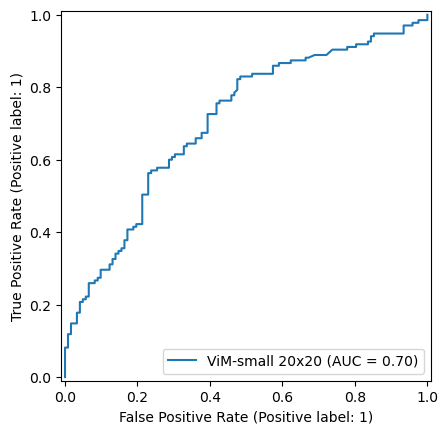

In [577]:
class_rocs['vim2020_zeroshot'].plot()

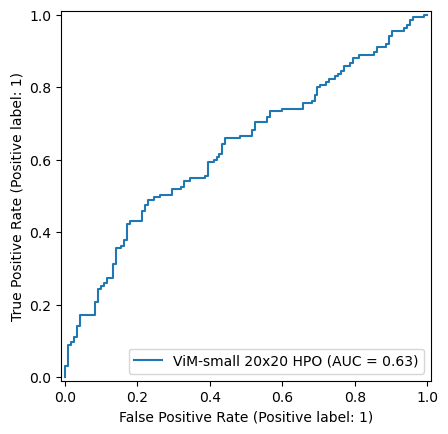

In [578]:
class_rocs['vim2020-hpo_zeroshot'].plot()

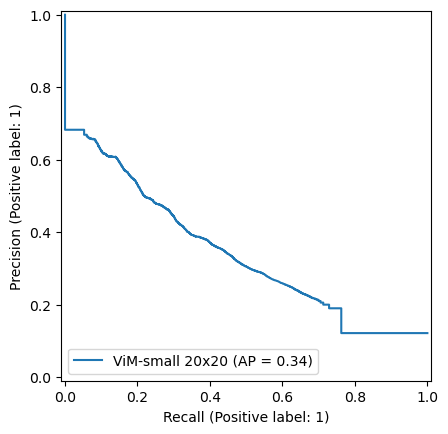

In [573]:
seg_prs['vim2020_hard'].plot()

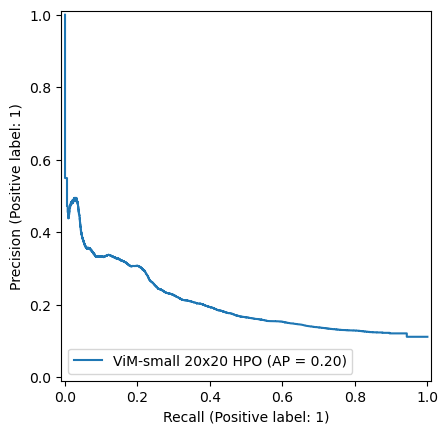

In [576]:
seg_prs['vim2020-hpo_zeroshot'].plot()

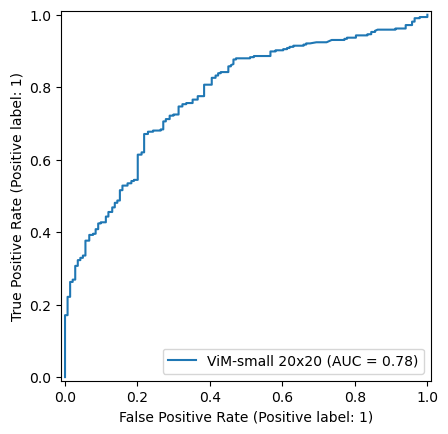

In [601]:
class_rocs_all['vim2020'].plot()
plt.savefig('vim2020-roc-all.png', bbox_inches='tight', transparent="True", pad_inches=0)

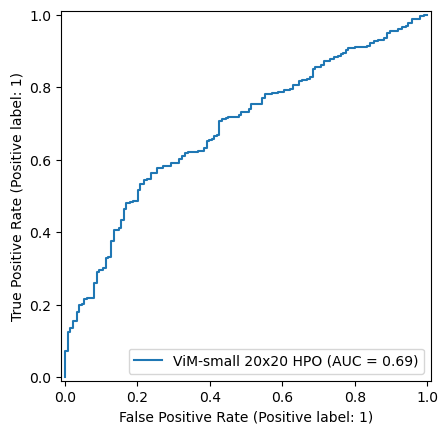

In [600]:
class_rocs_all['vim2020-hpo'].plot()
plt.savefig('vim2020-hpo-roc-all.png', bbox_inches='tight', transparent="True", pad_inches=0)

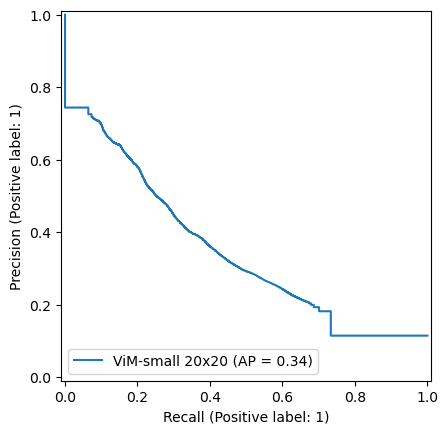

In [599]:
seg_prs_all['vim2020'].plot()
plt.savefig('vim2020-pr-all.png', bbox_inches='tight', transparent="True", pad_inches=0)

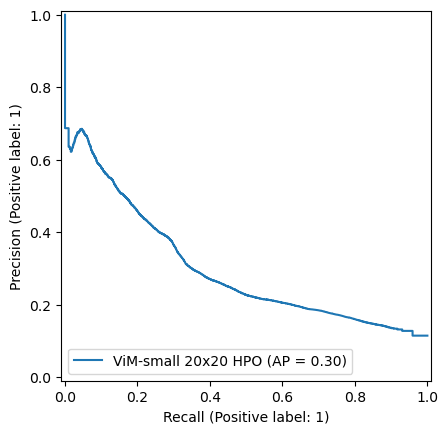

In [598]:
seg_prs_all['vim2020-hpo'].plot()
plt.savefig('vim2020-hpo-pr-all.png', bbox_inches='tight', transparent="True", pad_inches=0)